In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torch.functional import F
from typing import cast
from tqdm import tqdm
import random


%matplotlib inline
while not os.getcwd().endswith("nlp-playground"):
    os.chdir("..")
print(os.getcwd())
DATA_DIR = "data"
NAMES_FILE_PATH = os.path.join(DATA_DIR, "names.txt")

/Users/cristian/Personal/Projects/nlp-playground


Load the words

In [7]:
with open(NAMES_FILE_PATH, "r") as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [8]:
len(words)

32033

Build the dictionary mapping of the characters to their corresponding integer values

In [11]:
chars = ["."] + sorted(list(set("".join(words))))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
vocab_size = len(chars)
print(stoi)
print(itos)
print(vocab_size)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


Build the actual datased considering a sequence of block_size characters as input and the next character as the output

In [13]:
def build_dataset(words, block_size=None):
    if block_size is None:
        block_size = 3

    X, Y = [], []

    # iterate over words
    for word in words:
        # define a 3-character context window
        context = [0] * block_size
        # iterate over characters in the word
        for char in word + ".":
            # get the index of the character
            idx = stoi[char]
            X.append(context)
            Y.append(idx)
            # slide the context window one character to the right
            context = context[1:] + [idx]
    # convert the data to PyTorch tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


In [29]:
random.seed(42)
random.shuffle(words)
block_size = 3
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_tr, Y_tr = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_te, Y_te = build_dataset(words[n2:], block_size)

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [ ]:
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn(vocab_size, n_emb, generator=g, requires_grad=True)
W1 = torch.randn(block_size * n_emb, n_hidden, generator=g, requires_grad=True)
b1 = torch.randn(n_hidden, generator=g, requires_grad=True)
W2 = torch.randn(n_hidden, vocab_size, generator=g, requires_grad=True)
b2 = torch.randn(vocab_size, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

11897


In [31]:
max_steps = 200000
batch_size = 32
lossi = []

In [32]:
progress_bar = tqdm(range(max_steps), desc=f"Training")
for i in progress_bar:
    # build minibatch
    idx = torch.randint(0, X_tr.shape[0], (batch_size,))

    # Compute embeddings
    emb = C[X_tr[idx]]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[idx])
    progress_bar.set_postfix(loss=loss.item())
    # print(f"loss: {loss.item()}")

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        tqdm.write(f"{i:7d}/{max_steps:7d}: {loss.item()}")
    lossi.append(loss.log10().item())

Training:   0%|          | 241/200000 [00:00<02:45, 1205.51it/s, loss=5.69]

      0/ 200000: 25.61225700378418


Training:   1%|          | 1197/200000 [00:01<03:02, 1092.14it/s, loss=4.26]

   1000/ 200000: 2.8847508430480957


Training:   1%|          | 2170/200000 [00:01<02:47, 1181.69it/s, loss=3.75]

   2000/ 200000: 3.450000762939453


Training:   2%|▏         | 3150/200000 [00:02<02:49, 1160.80it/s, loss=2.18]

   3000/ 200000: 2.4936842918395996


Training:   2%|▏         | 4130/200000 [00:03<02:45, 1183.81it/s, loss=3.15]

   4000/ 200000: 3.0462582111358643


Training:   3%|▎         | 5227/200000 [00:04<02:40, 1213.25it/s, loss=2.96]

   5000/ 200000: 2.785365343093872


Training:   3%|▎         | 6210/200000 [00:05<02:43, 1187.40it/s, loss=3.1] 

   6000/ 200000: 2.8082351684570312


Training:   4%|▎         | 7166/200000 [00:06<02:51, 1121.54it/s, loss=2.4] 

   7000/ 200000: 2.2180397510528564


Training:   4%|▍         | 8119/200000 [00:07<02:43, 1175.42it/s, loss=2.41]

   8000/ 200000: 2.4046990871429443


Training:   5%|▍         | 9183/200000 [00:07<02:52, 1106.29it/s, loss=2.6] 

   9000/ 200000: 2.4543285369873047


Training:   5%|▌         | 10133/200000 [00:08<02:38, 1199.39it/s, loss=2.57]

  10000/ 200000: 2.517268419265747


Training:   6%|▌         | 11222/200000 [00:09<02:41, 1166.26it/s, loss=2.22]

  11000/ 200000: 2.5424296855926514


Training:   6%|▌         | 12183/200000 [00:10<02:35, 1209.92it/s, loss=2.14]

  12000/ 200000: 2.366710662841797


Training:   7%|▋         | 13141/200000 [00:11<02:44, 1134.94it/s, loss=2.59]

  13000/ 200000: 2.9909517765045166


Training:   7%|▋         | 14229/200000 [00:12<02:38, 1175.06it/s, loss=2.67]

  14000/ 200000: 2.2649266719818115


Training:   8%|▊         | 15186/200000 [00:13<02:38, 1163.96it/s, loss=2.9] 

  15000/ 200000: 2.734208583831787


Training:   8%|▊         | 16142/200000 [00:13<02:45, 1114.10it/s, loss=2.16]

  16000/ 200000: 2.7003705501556396


Training:   9%|▊         | 17167/200000 [00:14<02:43, 1118.39it/s, loss=2.31]

  17000/ 200000: 2.488553285598755


Training:   9%|▉         | 18214/200000 [00:15<02:48, 1076.53it/s, loss=2.34]

  18000/ 200000: 2.1007373332977295


Training:  10%|▉         | 19131/200000 [00:16<02:46, 1086.08it/s, loss=2.47]

  19000/ 200000: 2.7327921390533447


Training:  10%|█         | 20222/200000 [00:17<02:32, 1178.47it/s, loss=2.56]

  20000/ 200000: 2.461017370223999


Training:  11%|█         | 21205/200000 [00:18<02:29, 1197.46it/s, loss=2.34]

  21000/ 200000: 2.1205837726593018


Training:  11%|█         | 22186/200000 [00:19<02:31, 1170.69it/s, loss=2.22]

  22000/ 200000: 2.3766045570373535


Training:  12%|█▏        | 23158/200000 [00:19<02:24, 1222.93it/s, loss=2.25]

  23000/ 200000: 1.8513569831848145


Training:  12%|█▏        | 24136/200000 [00:20<02:28, 1180.95it/s, loss=2.48]

  24000/ 200000: 2.5262670516967773


Training:  13%|█▎        | 25118/200000 [00:21<02:27, 1188.57it/s, loss=2.49]

  25000/ 200000: 2.308318853378296


Training:  13%|█▎        | 26203/200000 [00:22<02:25, 1193.53it/s, loss=2.13]

  26000/ 200000: 1.9534039497375488


Training:  14%|█▎        | 27173/200000 [00:23<02:21, 1222.14it/s, loss=2.18]

  27000/ 200000: 2.3922338485717773


Training:  14%|█▍        | 28138/200000 [00:24<02:27, 1166.08it/s, loss=2.4] 

  28000/ 200000: 2.914886713027954


Training:  15%|█▍        | 29235/200000 [00:25<02:21, 1210.56it/s, loss=2.4] 

  29000/ 200000: 2.4321999549865723


Training:  15%|█▌        | 30216/200000 [00:25<02:16, 1245.31it/s, loss=2.62]

  30000/ 200000: 2.1949145793914795


Training:  16%|█▌        | 31187/200000 [00:26<02:21, 1193.08it/s, loss=2.6] 

  31000/ 200000: 2.411323070526123


Training:  16%|█▌        | 32177/200000 [00:27<02:21, 1187.45it/s, loss=2.31]

  32000/ 200000: 2.908726692199707


Training:  17%|█▋        | 33161/200000 [00:28<02:21, 1180.36it/s, loss=2.1] 

  33000/ 200000: 2.3166356086730957


Training:  17%|█▋        | 34236/200000 [00:29<02:18, 1197.84it/s, loss=2.21]

  34000/ 200000: 2.309490203857422


Training:  18%|█▊        | 35191/200000 [00:30<02:16, 1204.88it/s, loss=2.57]

  35000/ 200000: 2.4829940795898438


Training:  18%|█▊        | 36168/200000 [00:30<02:13, 1224.97it/s, loss=2.41]

  36000/ 200000: 2.202291488647461


Training:  19%|█▊        | 37144/200000 [00:31<02:15, 1201.06it/s, loss=2.13]

  37000/ 200000: 2.2351205348968506


Training:  19%|█▉        | 38141/200000 [00:32<02:16, 1186.87it/s, loss=2.42]

  38000/ 200000: 2.5512709617614746


Training:  20%|█▉        | 39121/200000 [00:33<02:12, 1216.99it/s, loss=2.11]

  39000/ 200000: 2.6583123207092285


Training:  20%|██        | 40218/200000 [00:34<02:12, 1209.30it/s, loss=2.85]

  40000/ 200000: 2.580247163772583


Training:  21%|██        | 41152/200000 [00:35<02:21, 1125.36it/s, loss=2.29]

  41000/ 200000: 2.4511289596557617


Training:  21%|██        | 42229/200000 [00:36<02:10, 1205.27it/s, loss=1.98]

  42000/ 200000: 2.456479787826538


Training:  22%|██▏       | 43170/200000 [00:36<02:13, 1172.61it/s, loss=2.61]

  43000/ 200000: 2.4365389347076416


Training:  22%|██▏       | 44210/200000 [00:37<02:15, 1148.49it/s, loss=2.4] 

  44000/ 200000: 1.9942700862884521


Training:  23%|██▎       | 45175/200000 [00:38<02:10, 1186.97it/s, loss=1.99]

  45000/ 200000: 2.3600049018859863


Training:  23%|██▎       | 46151/200000 [00:39<02:10, 1182.31it/s, loss=2.32]

  46000/ 200000: 2.451845645904541


Training:  24%|██▎       | 47121/200000 [00:40<02:12, 1154.27it/s, loss=2.17]

  47000/ 200000: 2.396394729614258


Training:  24%|██▍       | 48227/200000 [00:41<02:05, 1211.17it/s, loss=2.04]

  48000/ 200000: 1.9923776388168335


Training:  25%|██▍       | 49196/200000 [00:42<02:05, 1202.10it/s, loss=2.22]

  49000/ 200000: 2.2049500942230225


Training:  25%|██▌       | 50193/200000 [00:42<02:02, 1225.32it/s, loss=2.57]

  50000/ 200000: 2.3740601539611816


Training:  26%|██▌       | 51158/200000 [00:43<02:05, 1187.96it/s, loss=2.27]

  51000/ 200000: 2.653730869293213


Training:  26%|██▌       | 52138/200000 [00:44<02:03, 1194.57it/s, loss=2.28]

  52000/ 200000: 2.2914888858795166


Training:  27%|██▋       | 53128/200000 [00:45<02:04, 1181.94it/s, loss=2.72]

  53000/ 200000: 2.2320613861083984


Training:  27%|██▋       | 54117/200000 [00:46<02:01, 1202.49it/s, loss=2.26]

  54000/ 200000: 1.8575185537338257


Training:  28%|██▊       | 55216/200000 [00:47<02:01, 1194.19it/s, loss=2.06]

  55000/ 200000: 2.3980302810668945


Training:  28%|██▊       | 56203/200000 [00:47<01:57, 1225.24it/s, loss=2.4] 

  56000/ 200000: 2.4868485927581787


Training:  29%|██▊       | 57185/200000 [00:48<01:55, 1240.90it/s, loss=2.14]

  57000/ 200000: 2.362017869949341


Training:  29%|██▉       | 58153/200000 [00:49<02:00, 1180.03it/s, loss=2.73]

  58000/ 200000: 2.163804769515991


Training:  30%|██▉       | 59143/200000 [00:50<01:58, 1193.12it/s, loss=1.85]

  59000/ 200000: 2.192582607269287


Training:  30%|███       | 60241/200000 [00:51<01:54, 1225.48it/s, loss=2.2] 

  60000/ 200000: 2.2767693996429443


Training:  31%|███       | 61208/200000 [00:52<01:58, 1175.85it/s, loss=2.1] 

  61000/ 200000: 2.4345037937164307


Training:  31%|███       | 62196/200000 [00:52<01:54, 1200.62it/s, loss=2.4] 

  62000/ 200000: 1.9487111568450928


Training:  32%|███▏      | 63195/200000 [00:53<01:53, 1206.45it/s, loss=2.29]

  63000/ 200000: 2.1936869621276855


Training:  32%|███▏      | 64168/200000 [00:54<01:52, 1204.57it/s, loss=2.17]

  64000/ 200000: 2.2737128734588623


Training:  33%|███▎      | 65146/200000 [00:55<01:49, 1231.66it/s, loss=1.84]

  65000/ 200000: 2.1871495246887207


Training:  33%|███▎      | 66131/200000 [00:56<01:50, 1216.19it/s, loss=2.24]

  66000/ 200000: 2.732416868209839


Training:  34%|███▎      | 67228/200000 [00:56<01:51, 1185.67it/s, loss=2.5] 

  67000/ 200000: 2.527059316635132


Training:  34%|███▍      | 68216/200000 [00:57<01:50, 1196.11it/s, loss=2.27]

  68000/ 200000: 2.0569348335266113


Training:  35%|███▍      | 69199/200000 [00:58<01:47, 1211.88it/s, loss=2.33]

  69000/ 200000: 2.139300584793091


Training:  35%|███▌      | 70163/200000 [00:59<01:47, 1202.81it/s, loss=2.27]

  70000/ 200000: 2.1156396865844727


Training:  36%|███▌      | 71162/200000 [01:00<01:48, 1191.20it/s, loss=2.1] 

  71000/ 200000: 2.2424631118774414


Training:  36%|███▌      | 72132/200000 [01:01<01:44, 1223.17it/s, loss=2.24]

  72000/ 200000: 2.3055551052093506


Training:  37%|███▋      | 73240/200000 [01:01<01:42, 1233.29it/s, loss=2.13]

  73000/ 200000: 2.3979732990264893


Training:  37%|███▋      | 74213/200000 [01:02<01:47, 1171.58it/s, loss=1.89]

  74000/ 200000: 2.0647244453430176


Training:  38%|███▊      | 75205/200000 [01:03<01:44, 1188.62it/s, loss=1.98]

  75000/ 200000: 2.178807497024536


Training:  38%|███▊      | 76190/200000 [01:04<01:41, 1223.33it/s, loss=1.88]

  76000/ 200000: 1.965941071510315


Training:  39%|███▊      | 77134/200000 [01:05<01:47, 1139.34it/s, loss=2.73]

  77000/ 200000: 2.1645307540893555


Training:  39%|███▉      | 78124/200000 [01:06<01:42, 1187.34it/s, loss=2.34]

  78000/ 200000: 2.227570056915283


Training:  40%|███▉      | 79113/200000 [01:07<01:41, 1193.30it/s, loss=2.53]

  79000/ 200000: 2.0199975967407227


Training:  40%|████      | 80221/200000 [01:07<01:40, 1195.74it/s, loss=2.71]

  80000/ 200000: 1.9500869512557983


Training:  41%|████      | 81199/200000 [01:08<01:38, 1211.56it/s, loss=2.06]

  81000/ 200000: 2.4332797527313232


Training:  41%|████      | 82159/200000 [01:09<01:39, 1182.04it/s, loss=2.61]

  82000/ 200000: 2.237455129623413


Training:  42%|████▏     | 83141/200000 [01:10<01:38, 1185.63it/s, loss=1.77]

  83000/ 200000: 2.260098934173584


Training:  42%|████▏     | 84136/200000 [01:11<01:38, 1172.70it/s, loss=2.02]

  84000/ 200000: 2.3419532775878906


Training:  43%|████▎     | 85122/200000 [01:12<01:37, 1181.78it/s, loss=2.07]

  85000/ 200000: 2.487919807434082


Training:  43%|████▎     | 86221/200000 [01:12<01:37, 1171.93it/s, loss=2.2] 

  86000/ 200000: 2.212599754333496


Training:  44%|████▎     | 87196/200000 [01:13<01:37, 1161.76it/s, loss=2.47]

  87000/ 200000: 2.148620367050171


Training:  44%|████▍     | 88149/200000 [01:14<01:34, 1182.83it/s, loss=1.92]

  88000/ 200000: 2.444699764251709


Training:  45%|████▍     | 89132/200000 [01:15<01:33, 1189.06it/s, loss=2.26]

  89000/ 200000: 2.3693668842315674


Training:  45%|████▌     | 90232/200000 [01:16<01:30, 1218.41it/s, loss=2.39]

  90000/ 200000: 2.2003393173217773


Training:  46%|████▌     | 91188/200000 [01:17<01:32, 1172.82it/s, loss=1.83]

  91000/ 200000: 2.3945322036743164


Training:  46%|████▌     | 92167/200000 [01:17<01:30, 1191.68it/s, loss=2.09]

  92000/ 200000: 2.7200825214385986


Training:  47%|████▋     | 93169/200000 [01:18<01:30, 1182.84it/s, loss=2.09]

  93000/ 200000: 2.315903902053833


Training:  47%|████▋     | 94152/200000 [01:19<01:27, 1206.50it/s, loss=2.47]

  94000/ 200000: 1.9835317134857178


Training:  48%|████▊     | 95132/200000 [01:20<01:25, 1232.39it/s, loss=2.68]

  95000/ 200000: 2.233776569366455


Training:  48%|████▊     | 96226/200000 [01:21<01:25, 1210.35it/s, loss=2.23]

  96000/ 200000: 1.8697807788848877


Training:  49%|████▊     | 97186/200000 [01:22<01:35, 1073.78it/s, loss=1.67]

  97000/ 200000: 2.50788950920105


Training:  49%|████▉     | 98154/200000 [01:23<01:25, 1195.67it/s, loss=2.4] 

  98000/ 200000: 2.3863584995269775


Training:  50%|████▉     | 99130/200000 [01:23<01:21, 1240.03it/s, loss=2.02]

  99000/ 200000: 2.1807072162628174


Training:  50%|█████     | 100217/200000 [01:24<01:22, 1206.52it/s, loss=1.92]

 100000/ 200000: 2.055349588394165


Training:  51%|█████     | 101189/200000 [01:25<01:24, 1174.92it/s, loss=2.08]

 101000/ 200000: 1.7751133441925049


Training:  51%|█████     | 102172/200000 [01:26<01:21, 1194.78it/s, loss=1.94]

 102000/ 200000: 1.885825514793396


Training:  52%|█████▏    | 103156/200000 [01:27<01:21, 1195.53it/s, loss=2.29]

 103000/ 200000: 2.3605639934539795


Training:  52%|█████▏    | 104131/200000 [01:28<01:18, 1226.60it/s, loss=1.96]

 104000/ 200000: 2.3584988117218018


Training:  53%|█████▎    | 105228/200000 [01:28<01:17, 1219.63it/s, loss=1.96]

 105000/ 200000: 1.750152349472046


Training:  53%|█████▎    | 106206/200000 [01:29<01:18, 1191.19it/s, loss=2.39]

 106000/ 200000: 2.374819278717041


Training:  54%|█████▎    | 107196/200000 [01:30<01:18, 1183.79it/s, loss=1.87]

 107000/ 200000: 2.305331230163574


Training:  54%|█████▍    | 108188/200000 [01:31<01:20, 1142.96it/s, loss=2.05]

 108000/ 200000: 2.08137845993042


Training:  55%|█████▍    | 109169/200000 [01:32<01:16, 1187.46it/s, loss=2.25]

 109000/ 200000: 1.8322758674621582


Training:  55%|█████▌    | 110132/200000 [01:33<01:16, 1175.30it/s, loss=2.07]

 110000/ 200000: 2.12715482711792


Training:  56%|█████▌    | 111227/200000 [01:33<01:14, 1191.91it/s, loss=2.12]

 111000/ 200000: 1.7917159795761108


Training:  56%|█████▌    | 112215/200000 [01:34<01:14, 1170.90it/s, loss=2.24]

 112000/ 200000: 2.006443977355957


Training:  57%|█████▋    | 113196/200000 [01:35<01:12, 1189.55it/s, loss=2.13]

 113000/ 200000: 2.3978419303894043


Training:  57%|█████▋    | 114165/200000 [01:36<01:10, 1213.17it/s, loss=2.14]

 114000/ 200000: 2.1713485717773438


Training:  58%|█████▊    | 115121/200000 [01:37<01:12, 1174.20it/s, loss=2.42]

 115000/ 200000: 1.6801296472549438


Training:  58%|█████▊    | 116216/200000 [01:38<01:10, 1188.36it/s, loss=2.36]

 116000/ 200000: 2.0753750801086426


Training:  59%|█████▊    | 117200/200000 [01:38<01:09, 1194.03it/s, loss=2.32]

 117000/ 200000: 2.057286024093628


Training:  59%|█████▉    | 118184/200000 [01:39<01:09, 1182.01it/s, loss=2.12]

 118000/ 200000: 1.8616198301315308


Training:  60%|█████▉    | 119159/200000 [01:40<01:07, 1192.91it/s, loss=2.32]

 119000/ 200000: 2.1932711601257324


Training:  60%|██████    | 120138/200000 [01:41<01:05, 1221.33it/s, loss=2.19]

 120000/ 200000: 1.9066942930221558


Training:  61%|██████    | 121128/200000 [01:42<01:04, 1227.05it/s, loss=1.86]

 121000/ 200000: 2.8814151287078857


Training:  61%|██████    | 122223/200000 [01:43<01:04, 1203.96it/s, loss=2.09]

 122000/ 200000: 2.332716226577759


Training:  62%|██████▏   | 123218/200000 [01:43<01:04, 1196.70it/s, loss=1.97]

 123000/ 200000: 2.1563057899475098


Training:  62%|██████▏   | 124206/200000 [01:44<01:02, 1217.74it/s, loss=2.1] 

 124000/ 200000: 2.4828078746795654


Training:  63%|██████▎   | 125183/200000 [01:45<01:01, 1223.88it/s, loss=2]   

 125000/ 200000: 2.3191535472869873


Training:  63%|██████▎   | 126150/200000 [01:46<01:02, 1189.94it/s, loss=2.18]

 126000/ 200000: 1.7626621723175049


Training:  64%|██████▎   | 127135/200000 [01:47<01:02, 1168.90it/s, loss=2.46]

 127000/ 200000: 2.319838523864746


Training:  64%|██████▍   | 128119/200000 [01:48<01:00, 1183.65it/s, loss=2.03]

 128000/ 200000: 1.8932876586914062


Training:  65%|██████▍   | 129204/200000 [01:49<01:03, 1121.65it/s, loss=2]   

 129000/ 200000: 2.4361512660980225


Training:  65%|██████▌   | 130147/200000 [01:49<01:00, 1159.07it/s, loss=1.78]

 130000/ 200000: 2.1718156337738037


Training:  66%|██████▌   | 131210/200000 [01:50<00:58, 1168.91it/s, loss=2.03]

 131000/ 200000: 2.161431074142456


Training:  66%|██████▌   | 132176/200000 [01:51<00:58, 1162.59it/s, loss=2.2] 

 132000/ 200000: 2.329772710800171


Training:  67%|██████▋   | 133203/200000 [01:52<01:02, 1062.00it/s, loss=2.28]

 133000/ 200000: 2.0629382133483887


Training:  67%|██████▋   | 134212/200000 [01:53<00:58, 1131.41it/s, loss=2.1] 

 134000/ 200000: 2.043893575668335


Training:  68%|██████▊   | 135177/200000 [01:54<00:53, 1207.61it/s, loss=2.05]

 135000/ 200000: 2.1070563793182373


Training:  68%|██████▊   | 136146/200000 [01:55<00:54, 1161.30it/s, loss=2.09]

 136000/ 200000: 2.6339075565338135


Training:  69%|██████▊   | 137233/200000 [01:56<00:53, 1172.66it/s, loss=2.34]

 137000/ 200000: 2.3344173431396484


Training:  69%|██████▉   | 138180/200000 [01:57<00:52, 1180.22it/s, loss=2.32]

 138000/ 200000: 1.8540741205215454


Training:  70%|██████▉   | 139158/200000 [01:57<00:49, 1221.39it/s, loss=2.09]

 139000/ 200000: 2.142441987991333


Training:  70%|███████   | 140137/200000 [01:58<00:48, 1228.39it/s, loss=1.94]

 140000/ 200000: 2.3004910945892334


Training:  71%|███████   | 141228/200000 [01:59<00:48, 1212.44it/s, loss=2.25]

 141000/ 200000: 1.8655976057052612


Training:  71%|███████   | 142187/200000 [02:00<00:49, 1175.63it/s, loss=1.82]

 142000/ 200000: 2.2470767498016357


Training:  72%|███████▏  | 143174/200000 [02:01<00:46, 1210.08it/s, loss=1.88]

 143000/ 200000: 2.0232248306274414


Training:  72%|███████▏  | 144176/200000 [02:02<00:46, 1190.02it/s, loss=1.98]

 144000/ 200000: 2.180055856704712


Training:  73%|███████▎  | 145165/200000 [02:02<00:46, 1184.88it/s, loss=2.76]

 145000/ 200000: 2.191044807434082


Training:  73%|███████▎  | 146158/200000 [02:03<00:44, 1209.34it/s, loss=2.42]

 146000/ 200000: 2.0480966567993164


Training:  74%|███████▎  | 147118/200000 [02:04<00:45, 1165.69it/s, loss=2.15]

 147000/ 200000: 2.021182060241699


Training:  74%|███████▍  | 148217/200000 [02:05<00:42, 1207.77it/s, loss=2.19]

 148000/ 200000: 2.286648750305176


Training:  75%|███████▍  | 149197/200000 [02:06<00:42, 1184.22it/s, loss=2.17]

 149000/ 200000: 2.1145434379577637


Training:  75%|███████▌  | 150166/200000 [02:07<00:42, 1172.11it/s, loss=2.33]

 150000/ 200000: 2.51775860786438


Training:  76%|███████▌  | 151152/200000 [02:07<00:41, 1170.23it/s, loss=2.4] 

 151000/ 200000: 2.1932902336120605


Training:  76%|███████▌  | 152121/200000 [02:08<00:41, 1152.91it/s, loss=2.06]

 152000/ 200000: 1.9642406702041626


Training:  77%|███████▋  | 153220/200000 [02:09<00:39, 1181.86it/s, loss=2.06]

 153000/ 200000: 2.2255115509033203


Training:  77%|███████▋  | 154184/200000 [02:10<00:40, 1144.50it/s, loss=2.2] 

 154000/ 200000: 1.9147695302963257


Training:  78%|███████▊  | 155138/200000 [02:11<00:37, 1190.76it/s, loss=2.33]

 155000/ 200000: 1.9854497909545898


Training:  78%|███████▊  | 156219/200000 [02:12<00:36, 1192.83it/s, loss=2.3] 

 156000/ 200000: 1.9239885807037354


Training:  79%|███████▊  | 157194/200000 [02:13<00:35, 1197.14it/s, loss=2.26]

 157000/ 200000: 1.9943230152130127


Training:  79%|███████▉  | 158179/200000 [02:13<00:34, 1210.79it/s, loss=2.12]

 158000/ 200000: 2.171233654022217


Training:  80%|███████▉  | 159157/200000 [02:14<00:33, 1213.60it/s, loss=1.84]

 159000/ 200000: 2.2529823780059814


Training:  80%|████████  | 160236/200000 [02:15<00:33, 1196.24it/s, loss=2.14]

 160000/ 200000: 2.120514392852783


Training:  81%|████████  | 161222/200000 [02:16<00:33, 1159.50it/s, loss=2.25]

 161000/ 200000: 1.780804991722107


Training:  81%|████████  | 162184/200000 [02:17<00:32, 1170.00it/s, loss=2.19]

 162000/ 200000: 1.7489227056503296


Training:  82%|████████▏ | 163154/200000 [02:18<00:32, 1146.52it/s, loss=1.89]

 163000/ 200000: 2.3269314765930176


Training:  82%|████████▏ | 164227/200000 [02:19<00:31, 1149.38it/s, loss=2.16]

 164000/ 200000: 2.016123056411743


Training:  83%|████████▎ | 165202/200000 [02:19<00:30, 1155.78it/s, loss=1.76]

 165000/ 200000: 2.10675311088562


Training:  83%|████████▎ | 166171/200000 [02:20<00:30, 1125.24it/s, loss=2.34]

 166000/ 200000: 2.0171611309051514


Training:  84%|████████▎ | 167123/200000 [02:21<00:28, 1143.40it/s, loss=1.92]

 167000/ 200000: 2.5309481620788574


Training:  84%|████████▍ | 168198/200000 [02:22<00:27, 1170.07it/s, loss=2.38]

 168000/ 200000: 1.985196590423584


Training:  85%|████████▍ | 169153/200000 [02:23<00:27, 1136.65it/s, loss=2.35]

 169000/ 200000: 2.3116140365600586


Training:  85%|████████▌ | 170241/200000 [02:24<00:26, 1143.89it/s, loss=1.97]

 170000/ 200000: 1.923036813735962


Training:  86%|████████▌ | 171221/200000 [02:25<00:23, 1207.66it/s, loss=1.98]

 171000/ 200000: 2.192255973815918


Training:  86%|████████▌ | 172190/200000 [02:25<00:24, 1146.20it/s, loss=2.67]

 172000/ 200000: 1.83648681640625


Training:  87%|████████▋ | 173158/200000 [02:26<00:23, 1159.78it/s, loss=2.23]

 173000/ 200000: 2.261711835861206


Training:  87%|████████▋ | 174106/200000 [02:27<00:23, 1099.21it/s, loss=2.14]

 174000/ 200000: 1.969690203666687


Training:  88%|████████▊ | 175179/200000 [02:28<00:21, 1162.77it/s, loss=2.19]

 175000/ 200000: 2.400756597518921


Training:  88%|████████▊ | 176168/200000 [02:29<00:20, 1189.34it/s, loss=2.35]

 176000/ 200000: 2.339294910430908


Training:  89%|████████▊ | 177154/200000 [02:30<00:19, 1198.86it/s, loss=1.8] 

 177000/ 200000: 2.5396108627319336


Training:  89%|████████▉ | 178153/200000 [02:31<00:17, 1248.73it/s, loss=1.87]

 178000/ 200000: 2.283803939819336


Training:  90%|████████▉ | 179224/200000 [02:31<00:18, 1123.79it/s, loss=2.28]

 179000/ 200000: 1.826642632484436


Training:  90%|█████████ | 180180/200000 [02:32<00:16, 1168.54it/s, loss=1.92]

 180000/ 200000: 1.92389976978302


Training:  91%|█████████ | 181155/200000 [02:33<00:16, 1173.07it/s, loss=2.94]

 181000/ 200000: 2.4277992248535156


Training:  91%|█████████ | 182141/200000 [02:34<00:15, 1167.92it/s, loss=1.73]

 182000/ 200000: 2.2739903926849365


Training:  92%|█████████▏| 183248/200000 [02:35<00:13, 1212.31it/s, loss=2.14]

 183000/ 200000: 2.298973321914673


Training:  92%|█████████▏| 184222/200000 [02:36<00:13, 1210.71it/s, loss=2.26]

 184000/ 200000: 2.067533254623413


Training:  93%|█████████▎| 185205/200000 [02:36<00:12, 1194.01it/s, loss=2.2] 

 185000/ 200000: 2.4353840351104736


Training:  93%|█████████▎| 186175/200000 [02:37<00:11, 1165.47it/s, loss=2.1] 

 186000/ 200000: 2.15960431098938


Training:  94%|█████████▎| 187126/200000 [02:38<00:11, 1166.98it/s, loss=2.44]

 187000/ 200000: 2.2064898014068604


Training:  94%|█████████▍| 188106/200000 [02:39<00:10, 1160.11it/s, loss=2.17]

 188000/ 200000: 2.4328997135162354


Training:  95%|█████████▍| 189161/200000 [02:40<00:09, 1153.62it/s, loss=2.31]

 189000/ 200000: 2.029183864593506


Training:  95%|█████████▌| 190238/200000 [02:41<00:08, 1176.90it/s, loss=2.56]

 190000/ 200000: 2.028747320175171


Training:  96%|█████████▌| 191206/200000 [02:42<00:07, 1172.87it/s, loss=2.13]

 191000/ 200000: 2.256474733352661


Training:  96%|█████████▌| 192176/200000 [02:42<00:06, 1133.75it/s, loss=1.83]

 192000/ 200000: 2.2068779468536377


Training:  97%|█████████▋| 193136/200000 [02:43<00:05, 1147.40it/s, loss=2.09]

 193000/ 200000: 2.2642672061920166


Training:  97%|█████████▋| 194212/200000 [02:44<00:04, 1168.94it/s, loss=2.2] 

 194000/ 200000: 2.0324695110321045


Training:  98%|█████████▊| 195199/200000 [02:45<00:04, 1194.75it/s, loss=2.3] 

 195000/ 200000: 2.174323320388794


Training:  98%|█████████▊| 196176/200000 [02:46<00:03, 1169.12it/s, loss=2.42]

 196000/ 200000: 2.388099431991577


Training:  99%|█████████▊| 197138/200000 [02:47<00:02, 1184.26it/s, loss=2.43]

 197000/ 200000: 2.17435884475708


Training:  99%|█████████▉| 198124/200000 [02:48<00:01, 1183.76it/s, loss=1.91]

 198000/ 200000: 2.296539545059204


Training: 100%|█████████▉| 199210/200000 [02:48<00:00, 1161.86it/s, loss=2.32]

 199000/ 200000: 2.064976453781128


Training: 100%|██████████| 200000/200000 [02:49<00:00, 1179.33it/s, loss=2.3] 


In [26]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": {X_tr, Y_tr}, "val": {X_dev, Y_dev}, "test": {X_te, Y_te}}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.115760087966919
val 2.153362274169922


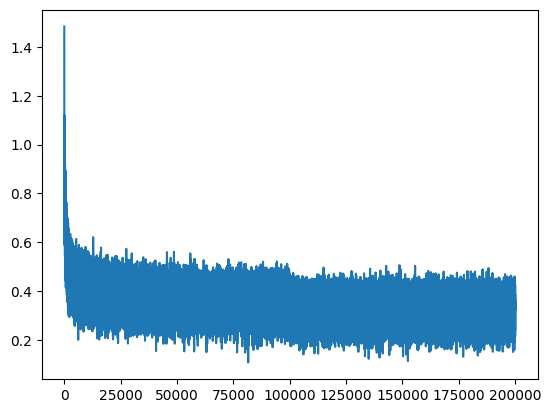

In [28]:
plt.plot(lossi)
plt.show()

In [94]:
emb = C[X_tr]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_tr)
loss

tensor(2.1655, grad_fn=<NllLossBackward0>)

In [95]:
emb = C[X_dev]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1916, grad_fn=<NllLossBackward0>)

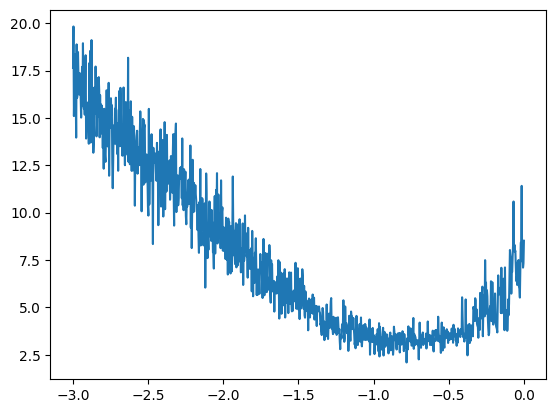

In [ ]:
plt.plot(lri, lossi)

In [52]:
C.shape

torch.Size([27, 2])

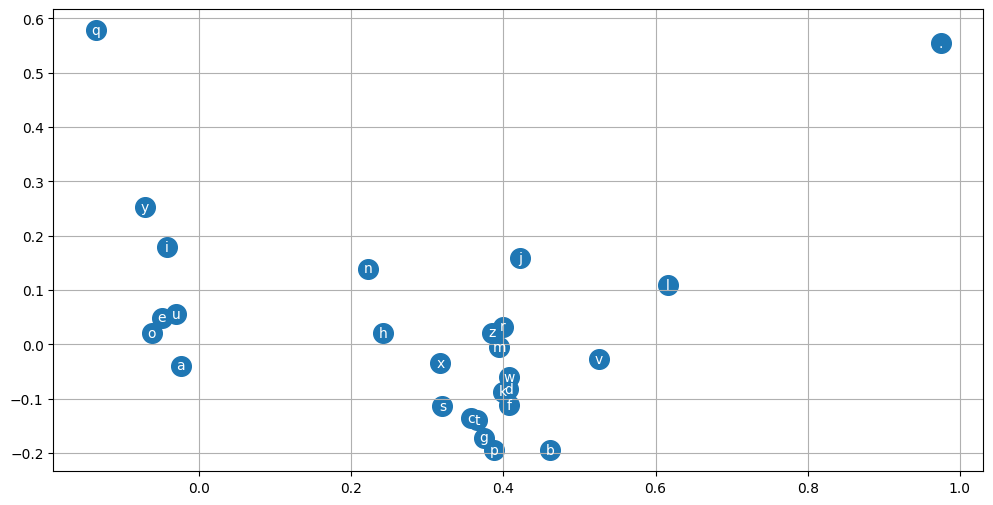

In [51]:
plt.figure(figsize=(12, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white"
    )
plt.grid("minor")

In [97]:
g = torch.Generator().manual_seed(42)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = logits.softmax(dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print("".join(itos[i] for i in out))

anuelen.
tia.
marian.
davius.
amillaylen.
kemarce.
man.
epiacenden.
dazi.
kence.
jordon.
kalla.
mikhlynna.
cvahia.
aczalin.
tian.
tiyan.
marotte.
jena.
judgan.
